In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import matplotlib.colors as mcolors

def load_time_curve(snr=None, th_acc=None, show_acc_range=False, show_out60sec=False, pretrained=False):
    print("\n-----------Loading SNR{}dB-------------".format(snr))
    
    path="./checkpoint2/gan/gan_vae_PA_fixed/",
    path_dict_load = np.load("./checkpoint2/gan/gan_vae_PA_fixed/plot_path_dict.npy", allow_pickle=True)
    path_dict_load = path_dict_load.item()  
    snrs = list(path_dict_load.keys())
    rfflabels = list(path_dict_load[snrs[0]])

    cnt=0
    acc_range=[(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.01)]
    cnt_range=[[] for _ in range(len(acc_range))]

    timer_curve_all={}
    for rfflabel in rfflabels:
        time_curve_file = path_dict_load[snr][rfflabel]['time']
        rfflabel_load = int(time_curve_file.split('_')[-1].split('.')[0])
        assert rfflabel == rfflabel_load
        dict_load = np.load(time_curve_file, allow_pickle=True).item()
        val_acc = dict_load[rfflabel][-1][-1]
        for i in range(len(acc_range)):
            (x,y) = acc_range[i]
            if x<=val_acc<y :
                cnt_range[i].append(rfflabel)
                cnt+=1
        if th_acc[0]<=val_acc<th_acc[1]: 
            timer_curve_all.update(dict_load)
                                
    print("#cnt_range:", cnt)
    if show_acc_range:
        for i in range(len(acc_range)):
            print("acc_range:{}, cnt:{}".format(acc_range[i], len(cnt_range[i])))

    rfflabels = list(timer_curve_all.keys())
    print("#{} rfflabels in time_curve_all: {}".format(len(rfflabels), rfflabels))
    print("#miss rfflabel:", 219-len(rfflabels), end=' ')
    for i in range(1, 220):
        if i not in rfflabels:
            print(i, end=', ')

    in60sec=[]
    out60sec=[]
    n_epochs=[]
    for rff in timer_curve_all.keys():
        test_time = timer_curve_all[rff][-2][-1]
        val_acc = timer_curve_all[rff][-1][-1]
        n_epochs.append(len(timer_curve_all[rff][0]))
        if test_time<=60:# and val_acc>=0.9:
            in60sec.append(rff)
        else:
            out60sec.append(rff)

    print("average n_epochs: {}".format(sum(n_epochs)/len(n_epochs)))
    print("{} rffs achive >={} within 60 sec: {}".format(len(in60sec), th_acc, in60sec))
    print("{} rffs achive >={} beyond 60 sec: {}".format(len(out60sec), th_acc, out60sec))

    if show_out60sec:
        for rff in out60sec:
            n_epoch = len(timer_curve_all[rff][-2])
            secs = timer_curve_all[rff][-2][-1]
            val_acc = timer_curve_all[rff][-1][-1]
            print("rff {} uses {} epochs, {} secs, achieving val_acc {}".format(rff, n_epoch, secs, val_acc))

    return timer_curve_all, acc_range, in60sec, out60sec

[]

-----------Loading SNR35dB-------------
#cnt_range: 220
#220 rfflabels in time_curve_all: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 

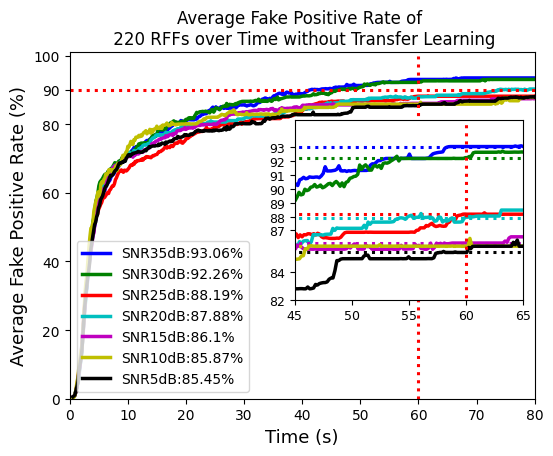

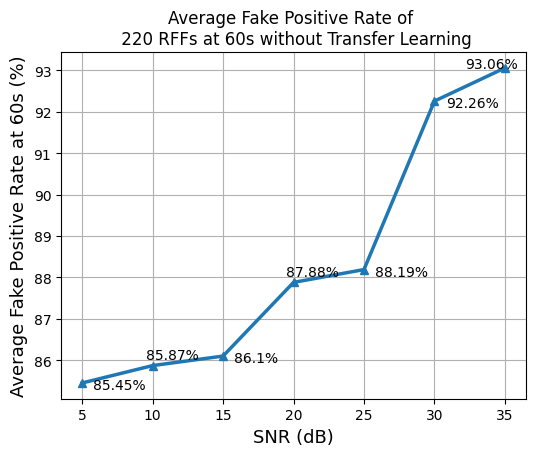

In [13]:
## Plot not tranfer results
def plot_timer_all(timer_curve_all_SNRs, transfer=False, snr_preset=None, in60sec_all_SNRs=None, out60sec_all_SNRs=None, SNRs=None, colors=None, linetypes=None, marks=None):
    print(colors)
    print(linetypes)
    print(marks)
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax_zoom = plt.axes([.50, .33, .38, .40])
    yticks_zoom=[]
    acc60all=[]
    time90=[]
    for SNR in SNRs:
        print("\n---------------Plot SNR{}dB----------------".format(SNR))
        timer_curve_all = timer_curve_all_SNRs[SNR]
        train_step_avg=[]
        test_step_avg=[]
        train_time_1stepoch=[]
        test_time_1stepoch=[]
        train_acc_avg=[]
        test_acc_avg=[]
        max_len=0
        for rfflabel in timer_curve_all.keys():
            if snr_preset and SNR not in snr_preset and rfflabel not in in60sec_all_SNRs:
                continue
            train_time_step, train_time, train_acc_fake_curve, test_time_step, test_time, val_acc_fake_curve = timer_curve_all[rfflabel]
            max_len = max(max_len, len(train_time_step))
            train_time_1stepoch.append(train_time_step[0])
            test_time_1stepoch.append(test_time_step[0])
            train_step_avg.append(np.mean(train_time_step[1:]))
            test_step_avg.append(np.mean(test_time_step[1:]))
            # print("rfflabel:{}, train/1st epoch time:{}, train/avg time step:{}, test/1st epoch time:{}, test/avg time step:{}".format(
            #     rfflabel, train_time_1stepoch[-1], train_step_avg[-1], test_time_1stepoch[-1], test_step_avg[-1]))

        train_time_1stepoch_avg = np.mean(train_time_1stepoch)
        test_time_1stepoch_avg = np.mean(test_time_1stepoch)
        train_step_avg = np.mean(train_step_avg)
        test_step_avg = np.mean(test_step_avg)
        train_time_curve = [train_time_1stepoch_avg]
        test_time_curve = [test_time_1stepoch_avg]
        print("train/avg 1st epoch time:{}, train/avg time step:{}, test/avg 1st epoch time:{}, test/avg time step:{}".format(
                train_time_1stepoch_avg, train_step_avg, test_time_1stepoch_avg, test_step_avg))

        for i in range(1, max_len - len(train_time_curve)+1):
            train_time_curve.append(train_time_curve[-1]+train_step_avg)

        for i in range(1, max_len - len(test_time_curve)+1):
            test_time_curve.append(test_time_curve[-1]+test_step_avg)

        for rfflabel in timer_curve_all.keys():
            if snr_preset and SNR!=snr_preset and rfflabel not in in60sec_all_SNRs:
                continue
            train_time_step, train_time, train_acc_fake_curve, test_time_step, test_time, val_acc_fake_curve = timer_curve_all[rfflabel]
            if val_acc_fake_curve[-1]==0:
                continue
            train_acc_fake_curve += [train_acc_fake_curve[-1] for i in range(1, max_len - len(train_acc_fake_curve)+1)]
            val_acc_fake_curve += [val_acc_fake_curve[-1] for i in range(1, max_len - len(val_acc_fake_curve)+1)]
            if train_acc_avg == []:
                train_acc_avg=train_acc_fake_curve
                test_acc_avg = val_acc_fake_curve
            else:
                train_acc_avg=[a+b for (a,b) in zip(train_acc_avg, train_acc_fake_curve)]
                test_acc_avg=[a+b for (a,b) in zip(test_acc_avg, val_acc_fake_curve)]
        n_labels = len(list(timer_curve_all.keys()))
        train_acc_avg = [x/n_labels for x in train_acc_avg]
        test_acc_avg = [x/n_labels for x in test_acc_avg]

        train_acc60, test_acc60 = 0, 0
        train_acc60_t, test_acc_60_t = 0, 0
        train_epoch, test_epoch = 0, 0
        for i in range(len(train_time_curve)):
            if 0<=60-train_time_curve[i]<1: # <0.15 when testing with tranfer learning results
            # if np.abs(train_time_curve[i]-60)<1:
                train_acc60 = max(train_acc60, train_acc_avg[i])
                train_acc60_t = train_time_curve[i]
                train_epoch = i
            if 0<=60-test_time_curve[i]<1:
            # if np.abs(test_time_curve[i]-60)<1e-1:
                test_acc60 = max(test_acc60, test_acc_avg[i])
                test_acc_60_t = test_time_curve[i]
                test_epoch = i

        max_train_time = train_time_curve[-1]
        max_test_time = test_time_curve[-1]
        train_acc60, test_acc60 = np.round(train_acc60, 4), np.round(test_acc60, 4)
        train_acc60_t, test_acc_60_t = np.round(train_acc60_t, 4), np.round(test_acc_60_t, 4)
        acc60all.append(100*test_acc60)
        print("train_acc60:{}, time:{}, epoch:{}; test_acc60:{}, time:{}, epoch:{}".format(train_acc60, train_acc60_t, train_epoch, test_acc60, test_acc_60_t, test_epoch))
        print("max_avg train_acc:{}, test_acc:{}".format(max(train_acc_avg), max(test_acc_avg)))
        print("train time last:{}, test time last:{}".format(max_train_time, max_test_time))
        df = pd.DataFrame({'train':train_acc_avg, 'test':test_acc_avg})

        # plt.plot(train_time_curve, df['train'], color=colors[SNR], linestyle=linetypes[0], label='SNR{}dB-train'.format(SNR))
        ax.plot(test_time_curve[:500], 100*df['test'][:500], color=colors[SNR], linestyle=linetypes[1], linewidth=2.5, label='SNR{}dB:{}%'.format(SNR, np.round(100*test_acc60,2)))
        # ax.plot(test_time_curve[:500], 100*df['test'][:500].rolling(10).mean(), color=colors[SNR][0], linestyle=linetypes[1])
        x_zoom = test_time_curve[200:400]
        y_zoom = 100*df['test'][200:400]
        ax_zoom.plot(x_zoom, y_zoom, color=colors[SNR], linewidth=2.5, label='SNR{}dB:{}%'.format(SNR, np.round(100*test_acc60,2)))
        ax_zoom.hlines(y=100*test_acc60, xmin=0, xmax=max_test_time, linewidth=2.2, colors=colors[SNR], linestyles='dotted')
        yticks_zoom.append(np.round(100*test_acc60,2))
    
    ax_zoom.set_ylim([82, 95])
    ax_zoom.set_xlim([45, 65])
    ax_zoom.set_yticks([82, 84, 87, 88, 89, 90, 91, 92, 93,])
    ax_zoom.vlines(x=60, ymin=81, ymax=95, linewidth=2.2, colors='r', linestyles='dotted') 
    ax_zoom.tick_params(axis='both', which='major', labelsize=9)
    # ax_zoom.grid()
    
    ax.vlines(x=60, ymin=0, ymax=100, linewidth=2.2, colors='r', linestyles='dotted')  
    ax.hlines(y=90, xmin=0, xmax=80, linewidth=2.2, colors='r', linestyles='dotted')  
    ax.set_ylim([0, 101])
    ax.set_xlim([0, 80])
    ax.set_yticks([0, 20, 40, 60, 80, 90, 100])
    ax.set_xlabel('Time (s)', fontsize=13)
    ax.set_ylabel('Average Fake Positive Rate (%)', fontsize=13)
    ax.set_title('Average Fake Positive Rate of \n 220 RFFs over Time without Transfer Learning')
    ax.legend(loc='lower left')
    plt.show()

    fig1, ax1 = plt.subplots(figsize=(6, 4.5))
    ax1.plot(SNRs, acc60all, marker='^', linewidth=2.5)
    ax1.set_xticks(SNRs)
    ax1.set_xlabel('SNR (dB)', fontsize=13)
    ax1.set_ylabel('Average Fake Positive Rate at 60s (%)', fontsize=13)
    ax1.set_title('Average Fake Positive Rate of \n 220 RFFs at 60s without Transfer Learning')
    ax1.text(x=SNRs[0]-2.8, y=acc60all[0], s='{}%'.format(np.round(acc60all[0],2))) 
    ax1.text(x=SNRs[1]+0.8, y=acc60all[1]-0.15, s='{}%'.format(np.round(acc60all[1],2)))   
    ax1.text(x=SNRs[2]+0.8, y=acc60all[2]-0.15, s='{}%'.format(np.round(acc60all[2],2)))  
    ax1.text(x=SNRs[3]-0.5, y=acc60all[3]+0.15, s='{}%'.format(np.round(acc60all[3],2)))  
    ax1.text(x=SNRs[4]+0.8, y=acc60all[4]-0.15, s='{}%'.format(np.round(acc60all[4],2))) 
    ax1.text(x=SNRs[5]-0.5, y=acc60all[5]+0.15, s='{}%'.format(np.round(acc60all[5],2))) 
    ax1.text(x=SNRs[6]+0.8, y=acc60all[6]-0.15, s='{}%'.format(np.round(acc60all[6],2))) 
    ax1.grid()
    # fig.savefig("./checkpoint2/results/figure/PA_fpr_timecurve_noTransfer.svg")
    # fig1.savefig("./checkpoint2/results/figure/PA_fpr_60s_noTransfer.svg")
    plt.show()

timer_curve_all_SNRs = {}
in60sec_all_SNRs=[]
out60sec_all_SNRs=[]
SNRs= [35, 30, 25, 20, 15, 10, 5]
ths_acc={5:(0, 1.01), 10:(0, 0.948), 15:(0, 1.01), 20:(0., 1.01), 25:(0, 1.01), 30:(0, 1.01), 35:(0, 1.01)} 
colors_list=list(mcolors.BASE_COLORS)[:len(SNRs)]
# colors_list=[['blue', 'lightblue'], ['green', 'lightgreen'], ['steelblue', 'skyblue'], ['mediumorchid', 'plum'], ['crimson', 'lightpink'], ['sandybrown','peachpuff'], ['darkgoldenrod', 'gold']]
colors={}
for i in range(len(SNRs)):
    colors[SNRs[i]] = colors_list[i]
linetypes=['-.', '-']
marks=['+', '*']

snr_preset = None #[35,]
in60sec_preset=[]
out60sec_preset=[]
if snr_preset:
    for snri in range(len(snr_preset)):
        snr = snr_preset[snri]
        _, _, in60sec, out60sec = load_time_curve(snr=snr, th_acc=ths_acc[snr], pretrained=False)
        if snri==0:
            in60sec_preset=in60sec
            out60sec_preset=out60sec
            continue
        for i in range(len(in60sec)):
            in60sec_preset = list(set(in60sec_preset) & set(in60sec))

print(in60sec_preset)    

for SNR in SNRs:
    timer_curve_all, _, in60sec, out60sec = load_time_curve(snr=SNR, th_acc=ths_acc[SNR], pretrained=False)
    timer_curve_all_SNRs[SNR] = timer_curve_all
    in60sec_all_SNRs+=in60sec
    out60sec_all_SNRs+=out60sec
print("in60sec rffs in total:{}".format(len(in60sec_all_SNRs)))
print("out60sec rffs in total:{}".format(len(out60sec_all_SNRs)))
plot_timer_all(timer_curve_all_SNRs, False, snr_preset, in60sec_preset, out60sec_preset, SNRs, colors, linetypes, marks)